# Student Loan Default Prediction
### Most Important Finding: 
- <b>Confounding Phenomenon</b>: A student is riskier than a non-student, if no information about the student's credit card balance is available. However, that student is less risky, than a non-student, with the same credit card balance
- <b>[Reccomendation to credit card companies](#reccomendation)</b>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sklearn.linear_model as skl_lm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import roc_curve, auc
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, precision_score
from sklearn import preprocessing
from sklearn import neighbors

import statsmodels.api as sm
import statsmodels.formula.api as smf

In [10]:
default = pd.read_excel('Data/Default.xlsx')
# keeping a copy of raw data
df = pd.read_excel('Data/Default.xlsx')

C:\Users\jaspr\Anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [11]:
default['default2'] = default.default.factorize()[0]
default['student2'] = default.student.factorize()[0]
default.head()

,Unnamed: 0,default,student,balance,income,default2,student2
0,1,No,No,729.526495,44361.625074,0,0
1,2,No,Yes,817.180407,12106.134700,0,1
2,3,No,No,1073.549164,31767.138947,0,0
3,4,No,No,529.250605,35704.493935,0,0
4,5,No,No,785.655883,38463.495879,0,0


In [16]:
import matplotlib as mpl
import seaborn as sns


# Note: factorize() returns two objects: a label array and an array with the unique values.
# We are only interested in the first object. 
df['default2'] = df.default.factorize()[0]
df['student2'] = df.student.factorize()[0]


## 4.3 Simple Logistic Regression

$$Pr(y=1|X)=\frac{e^{\beta_0 + \beta_1X}}{1+e^{\beta_0 + \beta_1X}}$$

#### Scikit-Learn

In [6]:
# Let's use balance as our predictor
X_balance = default.balance.values.reshape(-1,1)
y = default.default2

clf = skl_lm.LogisticRegression(solver='newton-cg')
clf.fit(X_balance, y)
print('classes:', clf.classes_)
print('coefficient:', clf.coef_)
print('intercept term:', clf.intercept_)

classes: [0 1]
coefficient: [[0.00549892]]
intercept term: [-10.65133011]


#### Stats-Models

Now, with this model, we can estimate the probabilty that someone will default on their credit card, given their card balance. We just need to plug in our coefficients into the sigmoid (logistic) function along with their bank balance. Let's assume their balance is $1000. 

In [40]:
X_train = sm.add_constant(df.balance)
est = sm.Logit(y.ravel(), X_train).fit()
est.summary2().tables[1]

Optimization terminated successfully.
         Current function value: 0.079823
         Iterations 10


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
const,-10.651331,0.361169,-29.491287,3.723665e-191,-11.359208,-9.943453
balance,0.005499,0.000220,24.952404,2.010855e-137,0.005067,0.005931


In [41]:
X_train = sm.add_constant(df.student2)
y = df.default2

est = sm.Logit(y, X_train).fit()
est.summary2().tables[1]

Optimization terminated successfully.
         Current function value: 0.145434
         Iterations 7


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
const,-3.504128,0.070713,-49.554094,0.000000,-3.642723,-3.365532
student2,0.404887,0.115019,3.520177,0.000431,0.179454,0.630320


___
- +ve coefficient value for student, along with statisticallly significant p-value, indicates that for a fixed value of balance and income, a students are more likely to to default, than a non-student
___

In [161]:
# est.params[0] is the intercept term derived from our model above, -10.6513
# est.params[1] is the slope term derived from our model above, 0.0055
prob_default = (np.exp(est.params[0]+est.params[1]*1000)) / (1 + (np.exp(est.params[0]+est.params[1]*1000)))
prob_default

0.0057521450680737569

We can interpret this as a .6% chance that they will default on their credit card. However, if their card balance is $2000, the estimated probability that they'll default rises to 59% as shown below.

In [162]:
prob_default = (np.exp(est.params[0]+est.params[1]*2000)) / (1 + (np.exp(est.params[0]+est.params[1]*2000)))
prob_default

0.58576936983133143

In [163]:
prob_default = (np.exp(est.params[0]+est.params[1]*1937)) / (1 + (np.exp(est.params[0]+est.params[1]*1937)))
prob_default

0.50001787048806834

---

In [164]:
X_student = sm.add_constant(default.student2)
est = smf.Logit(y.ravel(), X_student).fit()
est.summary().tables[1]

Optimization terminated successfully.
         Current function value: 0.145434
         Iterations 7


,coef,std err,z,P>|z|,[0.025,0.975]
const,-3.5041,0.071,-49.554,0.000,-3.643,-3.366
student2,0.4049,0.115,3.520,0.000,0.179,0.630


In [165]:
prob_default_student = (np.exp(est.params[0]+est.params[1]*1)) / (1 + (np.exp(est.params[0]+est.params[1]*1)))
prob_default_not_student = (np.exp(est.params[0]+est.params[1]*0)) / (1 + (np.exp(est.params[0]+est.params[1]*0)))
print(prob_default_student)
print(prob_default_not_student)

0.0431385869565
0.0291950113379


As shown by the p-values above, whether or not the card-holder is a student is a significant predictor of whether or not they'll default as well. In fact, if they're a student we estimate that their chances of defaulting double!

### Multivariate Logistic Regression

$$Pr(y=1|X)=\frac{e^{\beta_0 + \beta_1X_1+\dots+\beta_pX_p}}{1+e^{\beta_0 + \beta_1X_1+\dots+\beta_pX_p}}$$

#### Scikit-Learn

In [36]:
X = default[['balance', 'income', 'student2']]
y = default.default2

# Notice that these coefficients are different than those output by Statsmodel below. When I use the 'newton-cg' solver,
# I achieve the same coefficients, but am warned that the algorithm does not converge. Not sure how to interpret this.
clf = skl_lm.LogisticRegression()
clf.fit(X, y)
print('classes:', clf.classes_)
print('coefficient:', clf.coef_)
print('intercept term:', clf.intercept_)

classes: [0 1]
coefficient: [[ 4.08201022e-03 -1.33893466e-04 -3.89009045e+00]]
intercept term: [-2.9508496]


In [37]:
import statsmodels.api as sm

In [38]:
X_train = sm.add_constant(df[['balance', 'income', 'student2']])
# est = smf.Logit(y, X_train).fit()



# building the model and fitting the data
est = sm.Logit(y, X_train).fit()
est.summary2().tables[1]

Optimization terminated successfully.
         Current function value: 0.078577
         Iterations 10


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
const,-10.869045,0.492273,-22.079320,4.995499e-108,-11.833882,-9.904209
balance,0.005737,0.000232,24.736506,4.331521e-135,0.005282,0.006191
income,0.000003,0.000008,0.369808,7.115254e-01,-0.000013,0.000019
student2,-0.646776,0.236257,-2.737595,6.189022e-03,-1.109831,-0.183721


___
- -ve coefficient value fir student in the multiple log reg indicates, that for a fixed value of balance and income, a student is less likely to to default, than a non-student
___

## Confounding

In [19]:
# In R, I exported the dataset from package 'ISLR' to an Excel file
df = pd.read_excel('Data/Default.xlsx')

# Note: factorize() returns two objects: a label array and an array with the unique values.
# We are only interested in the first object. 
df['default2'] = df.default.factorize()[0]
df['student2'] = df.student.factorize()[0]
df.head(3)

C:\Users\jaspr\Anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,Unnamed: 0,default,student,balance,income,default2,student2
0,1,No,No,729.526495,44361.625074,0,0
1,2,No,Yes,817.180407,12106.134700,0,1
2,3,No,No,1073.549164,31767.138947,0,0


In [20]:
# balance and default vectors for students
X_train = df[df.student == 'Yes'].balance.values.reshape(df[df.student == 'Yes'].balance.size,1) 
y = df[df.student == 'Yes'].default2

# balance and default vectors for non-students
X_train2 = df[df.student == 'No'].balance.values.reshape(df[df.student == 'No'].balance.size,1) 
y2 = df[df.student == 'No'].default2

# Vector with balance values for plotting
X_test = np.arange(df.balance.min(), df.balance.max()).reshape(-1,1)

clf = skl_lm.LogisticRegression(solver='newton-cg')
clf2 = skl_lm.LogisticRegression(solver='newton-cg')

clf.fit(X_train,y)
clf2.fit(X_train2,y2)

prob = clf.predict_proba(X_test)
prob2 = clf2.predict_proba(X_test)

In [21]:
df.groupby(['student','default']).size().unstack('default')

default,No,Yes
student,,
No,6850,206
Yes,2817,127


C:\Users\jaspr\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


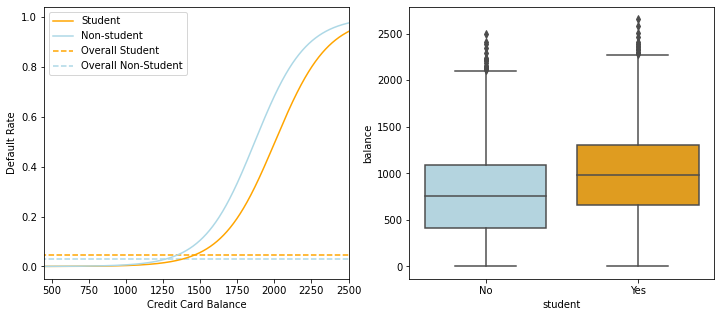

In [22]:
# creating plot
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))

# Left plot
ax1.plot(X_test, pd.DataFrame(prob)[1], color='orange', label='Student')
ax1.plot(X_test, pd.DataFrame(prob2)[1], color='lightblue', label='Non-student')
ax1.hlines(127/2817, colors='orange', label='Overall Student',
           xmin=ax1.xaxis.get_data_interval()[0],
           xmax=ax1.xaxis.get_data_interval()[1], linestyles='dashed')
ax1.hlines(206/6850, colors='lightblue', label='Overall Non-Student',
           xmin=ax1.xaxis.get_data_interval()[0],
           xmax=ax1.xaxis.get_data_interval()[1], linestyles='dashed')
ax1.set_ylabel('Default Rate')
ax1.set_xlabel('Credit Card Balance')
ax1.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.])
ax1.set_xlim(450,2500)
ax1.legend(loc=2)

# Right plot
sns.boxplot('student', 'balance', data=df, orient='v', ax=ax2,  palette=c_palette);

___
### Mismatch of results between SLR & MLR?
- How is it possible for student status to be associated with an increase in probability of default in SLR model, and a decrease in probability of default in MLR model?

- The right-hand panel of above figure provides an explanation for this discrepancy
- The variables student and balance are correlated. Students tend to hold higher levels of debt, which is in turn associated with higher probability of default
- In other words, students are more likely to have large credit card balances, which, as we know from the left-hand panel of Figure, tend to be associated with high default rates. 
- Thus, even though an individual student with a given credit card balance will tend to have a lower probability of default than a non-student with the same credit card balance, the fact that students on the whole tend to have higher credit card balances means that overall, students tend to default at a higher rate than non-students
___

<a id='reccomendation'></a>
### Reccomendation to credit card companies
This is an important distinction for a credit card company that is trying to determine to whom they should offer credit

---

#### Quick Comparison of Logistic Regression and Linear Discriminant Analysis

It can be show mathematically that in a two class classification problem, Logistic Regression and LDA take the same form. Where they differ is in how the parameters are estimated. 
* Logistic REgression uses the conditional likelihood based on $Pr(Y|X)$ (known as discriminative learning)
* LDA uses the full likelihood based on $PR(X|Y)$ (known as generative learning)

---